# Diabetes Prediction Tutorial
## Spring 2024 Data Science Project
Names: Aaryan Patel, Eileen Chen, Landon Badstibner

This is a tutorial that will walk you through the entire data science pipeline and makes use of a Diabetes Prediction Dataset that can be used to predict how likely a patient is to develop diabetes. It is a collection of
medical records and demographic data from patients. The selection of the dataset is due to its comprehensive nature, incorporating a wealth of medical and demographic data essential for predictive modeling. The dataset holds features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level, providing a holistic view of patients' health profiles. This makes it an ideal choice for constructing machine
learning models aimed at predicting diabetes based on both medical history and demographic information. We selected this dataset as it provides a lot of information with multiple factors that will allow us to perform preprocessing. The quantitative data points will also allow us to run machine learning classification algorithms later on. The predictive power of such models can
assist healthcare professionals in early identification of individuals at risk, enabling the formulation of tailored treatment plans.

Our first step is to import the libraries necessary to conduct this data analysis.

In [ ]:
# Import all of the following libraries.
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency

# Data Curation

This dataset was found and used from the following open-source site for datasets: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

First, we must load the dataset into a Pandas Dataframe. We'll call it "df." If necessary, change the filepath below to reflect the location of the dataset on your local computer.

For more information on the Pandas library: https://pandas.pydata.org/docs/getting_started/index.html#getting-started

In [ ]:
# Load the dataset into the dataframe.
df = pd.read_csv('/content/diabetes_prediction_dataset.csv')

Let's see what the dataset looks like! To do this, we can view the first 5 rows using df.head().

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


We must conduct some initial data cleaning. Let's check for duplicate rows first. To do this, we compare the number of rows in the dataframe to the number of rows after dropping exact duplicate rows with df.drop_duplicates().

In [ ]:
total_rows = len(df)
dups_dropped = len(df.drop_duplicates())
print("Number of Rows: " + str(total_rows))
print("Number of Rows Without Duplicates: " + str(dups_dropped))

Number of Rows: 100000
Number of Rows Without Duplicates: 96146


We have found duplicate rows in the dataset. However, the variables of this dataset are Gender, Age, Hypertension, Heart Disease, Smoking History, BMI, HbA1c Level, Blood Glucose Level, and Diabetes. Since none of these columns are identifying a specific person, each row is assumed to be a separate patient. Thus, we will keep the rows considered to be "duplicates."

Now, we must check for missing values. We can do this using df.isnull().sum(), which will count the total number of missing values for each column within the dataset.

In [ ]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Each column returned 0, so we have no missing values in the dataset.

Lastly, we must parse the dataset. This involves converting any columns that have a string datatype into numerical data, so that we may conduct further analysis. Let's check the type of each column using df.dtypes.

In [ ]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

From the output, we see that the Gender and Smoking History columns represent data as strings. We must convert those to numerical types. Let's start with smoking history.

In [ ]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

There are six categories within smoking history. Since the "No Info" category has the highest frequency, we cannot treat it as missing data. So, we will translate each category to a number from 1-6 using a python function.

In [ ]:
def translate_smoking(category):
  if category == "No Info":
    return 1
  elif category == "never":
    return 2
  elif category == "former":
    return 3
  elif category == "current":
    return 4
  elif category == "not current":
    return 5
  else:
    return 6

# Use df.apply() to apply the python function to each entry in the column.
df['smoking_history'] = df['smoking_history'].apply(translate_smoking)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,2,25.19,6.6,140,0
1,Female,54.0,0,0,1,27.32,6.6,80,0
2,Male,28.0,0,0,2,27.32,5.7,158,0
3,Female,36.0,0,0,4,23.45,5.0,155,0
4,Male,76.0,1,1,4,20.14,4.8,155,0


Now, let's deal with the Gender column. Let's find out the categories within the column.

In [ ]:
df['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

We can make a bar graph to better represent these categories.

In [ ]:
gender_counts = df['gender'].value_counts()
fig = px.bar(x=gender_counts.index, y=gender_counts.values, title='Distribution of Gender')
fig.update_layout(xaxis_title='Gender', yaxis_title='Count', showlegend=False)
fig.show()

We have a third category for "Other." Since there are only 18 entries for this category, we must either drop these rows or impute them. We shall use Hot-Deck Imputation to infer the gender based on the similarity of variables with other rows.

In [ ]:
# Hot-Deck Imputation Code

# Check if there are missing gender values
if 'Other' in df['gender'].unique():
    # Filter out rows with known gender
    known_gender = df[df['gender'] != 'Other']

    # Filter rows with missing gender
    missing_gender = df[df['gender'] == 'Other']

    # Check if there are rows with missing gender
    if not missing_gender.empty:
        # Calculate similarity scores without smoking_history column
        similarity_scores = cosine_similarity(missing_gender[['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']],
                                              known_gender[['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']])

        # Find the index of the most similar case for each missing gender entry
        most_similar_index = similarity_scores.argmax(axis=1)

        # Impute gender based on the majority gender of the most similar case
        imputed_gender = known_gender.iloc[most_similar_index]['gender'].values

        # Update the missing gender values in the original dataframe
        df.loc[df['gender'] == 'Other', 'gender'] = imputed_gender

        # Validate imputation results
        print(df['gender'].value_counts())
    else:
        print("No missing gender values to impute.")
else:
    print("No 'other' gender values to impute.")

gender
Female    58566
Male      41434
Name: count, dtype: int64


To conduct further data analysis, we will also convert this column to a numerical representation using 0's and 1's.

In [ ]:
def translate_gender(category):
  if category == "Female":
    return 0
  else:
    return 1

# Use df.apply() to apply the python function to each entry in the column.
df['gender'] = df['gender'].apply(translate_gender)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,2,25.19,6.6,140,0
1,0,54.0,0,0,1,27.32,6.6,80,0
2,1,28.0,0,0,2,27.32,5.7,158,0
3,0,36.0,0,0,4,23.45,5.0,155,0
4,1,76.0,1,1,4,20.14,4.8,155,0


# Exploratory Data Analysis


We will now conduct some basic exploratory data analysis to better understand our dataset. To do this, we will conduct an ANOVA test, a T-Test, and look for correlations between columns as well as outliers.

### Method 1: T Test

Here we are examining the correlation between diabetes with hypertension using a t test. This evaluation checks if there is a significant difference between the presence on hypertension on the likelihood of diabetes.
HA: Hypothesis_status = 'Alternate Hypothesis - Statistical difference, there is correlation between Diabetes and Hypertension'
H0: Hypothesis_status = 'Null Hypothesis - No Statistical difference, there is no correlation between Diabetes and Hypertension'

For beginner and advanced readers, more information on t-test is here: https://www.geeksforgeeks.org/t-test/

t_Test Evaluation (Diabetes Vs Hypertension)
T-Test Value : 8.370897080464712
p-Value : 5.75432045680587e-17
Hypothesis Status : Alternate Hypothesis - Statistical difference, there is correlation between Diabetes and Hypertension


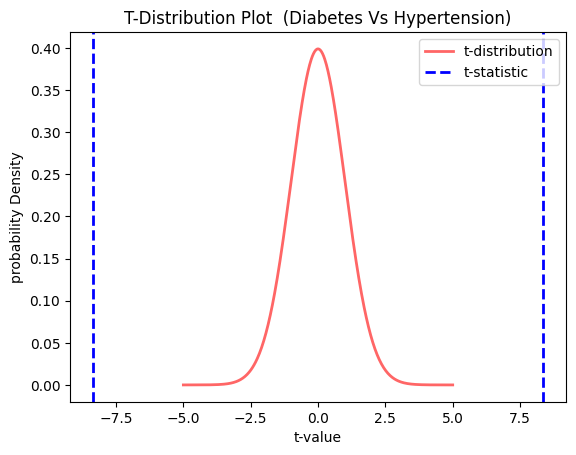

In [ ]:
group1 = df['diabetes']
group2 = df['hypertension']
t_stat, p_val = stats.ttest_ind(group1, group2)

print("t_Test Evaluation (Diabetes Vs Hypertension)")
print("T-Test Value :", t_stat)
print("p-Value :", p_val)

if (p_val<0.5):
  Hypothesis_status = 'Alternate Hypothesis - Statistical difference, there is correlation between Diabetes and Hypertension'
else:
  Hypothesis_status = 'Null Hypothesis - No Statistical difference, there is no correlation between Diabetes and Hypertension'

print("Hypothesis Status :", Hypothesis_status)

x = np.linspace(-5, 5, num=500)
y = stats.t.pdf(x, len(group1)+len(group2)-2)

fix, ax = plt.subplots()
ax.plot(x, y, 'r-', lw=2, alpha=0.6, label='t-distribution')
ax.axvline(t_stat, color='blue', linestyle='--', lw=2, label='t-statistic')
ax.axvline(-t_stat, color='blue', linestyle='--', lw=2)
ax.fill_betweenx(y, x, t_stat, where=x>=t_stat, color='blue', alpha=0.1)
ax.fill_betweenx(y, x, -t_stat, where=x<=-t_stat, color='blue', alpha=0.1)
ax.legend(loc='best')
ax.set(title='T-Distribution Plot  (Diabetes Vs Hypertension)', xlabel='t-value', ylabel='probability Density')
plt.show()

###Method 2: Correlation and Outliers

Let's look and see if any pairs of columns are correlated. This means finding if any two variables in the dataset are positively correlated, negatively correlated, or not correlated at all.

To do this, we can use df.corr(), which will generate Pearson Correlation Coefficients for each possible pair of numerical columns in the dataset. Additionally, we can create a heatmap using seaborn to better visualize which correlation coefficients are stronger.

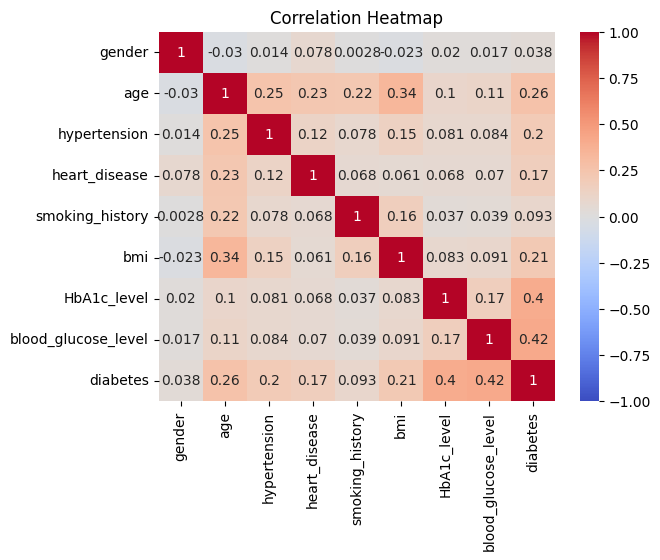

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

To find correlations between two variables, we must find correlation coefficients that are closer to either 1 or -1, as these indicate stronger correlations.

We ignore the coefficients of 1 across the diagonal of the matrix, as that is just comparing the column to itself.

There are two correlation coefficients of note: 0.42 and 0.4. While not indicating a very strong correlation, they are the strongest correlation coefficients present.

Let's explore the first correlation of 0.42 between Diabetes and Blood Glucose Level. We can create a scatterplot to represent the correlation using df.plot.scatter().

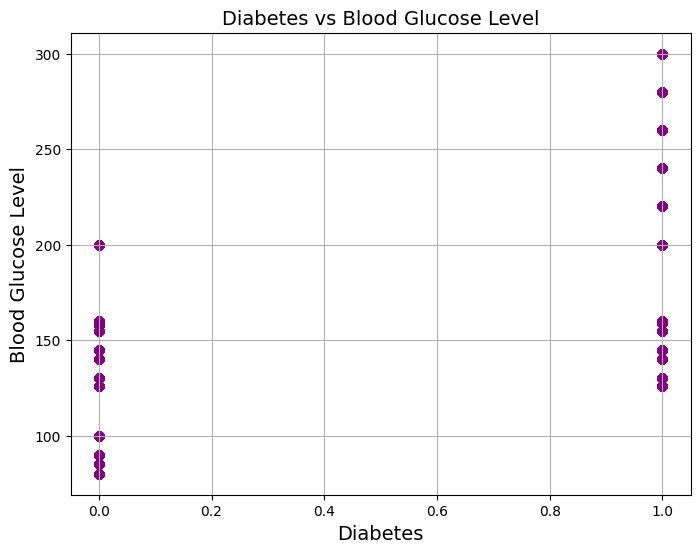

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df["diabetes"], df["blood_glucose_level"], color='purple')
plt.title("Diabetes vs Blood Glucose Level", fontsize=14)
plt.xlabel("Diabetes", fontsize=14)
plt.ylabel("Blood Glucose Level", fontsize=14)
plt.grid(True)
plt.show()

Based on this visual, we can see that in general, people with Diabetes typically have higher Blood Glucose Levels, which is to be expected!

Now, let's explore the relationship between HbA1c Level and Diabetes, which had a correlation of 0.4. We can create a scatter plot for this as well.

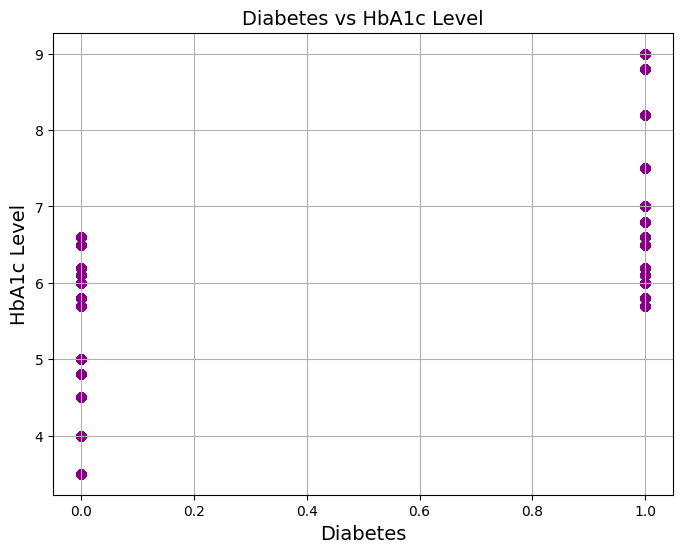

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df["diabetes"], df["HbA1c_level"], color='purple')
plt.title("Diabetes vs HbA1c Level", fontsize=14)
plt.xlabel("Diabetes", fontsize=14)
plt.ylabel("HbA1c Level", fontsize=14)
plt.grid(True)
plt.show()

As before, we can see that generally, people with diabetes have higher HbA1c Levels, which is also to be expected!

However, what if we want to compare the relationship between Blood Glucose Level and HbA1c levels, and how these two measures can predict diabetes based on their values? We've seen that for both variables, people with diabetes have higher counts on both. Let's create a different kind of scatterplot to visualize this using seaborn.

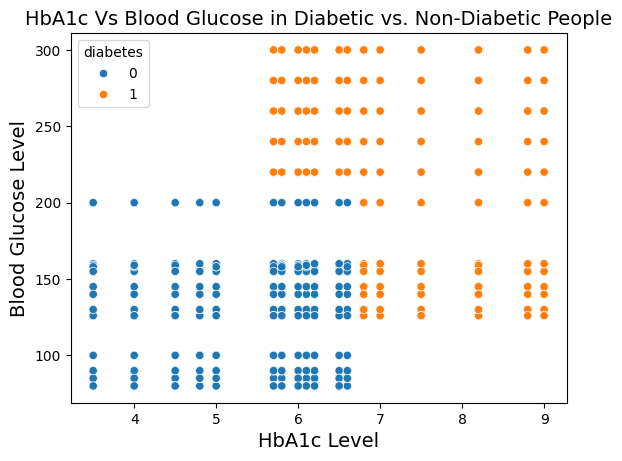

In [ ]:
sns.scatterplot(x = 'HbA1c_level', y = 'blood_glucose_level', hue = 'diabetes', data = df)
plt.title('HbA1c Vs Blood Glucose in Diabetic vs. Non-Diabetic People', fontsize=14)
plt.xlabel('HbA1c Level', fontsize=14)
plt.ylabel('Blood Glucose Level', fontsize=14)

plt.show()

This is a much better visual! Here, we can see that a higher HbA1c Level and higher Blood Glucose Level are indicators that the patient has diabetes.

All in all, we can say there exists moderately positive correlations between Blood Glucose Level and Diabetes, as well as between HbA1c Level and Diabetes.

Finally, let's check for outliers within our dataset. We do this to ensure that these outliers will not skew our data analysis in any way, and to consider removing them if they will.

The most common method of outlier detection is through box and whisker plots. We'll create boxplots to graph the distribution of values within each column. If outliers are present, they will be represented as lone dots at either extreme end of the boxplot.

We will ignore the columns for Hypertension, Heart Disease, and Diabetes, as those columns represent their data as either a 0 or 1. The boxplots for those columns will be misleading.

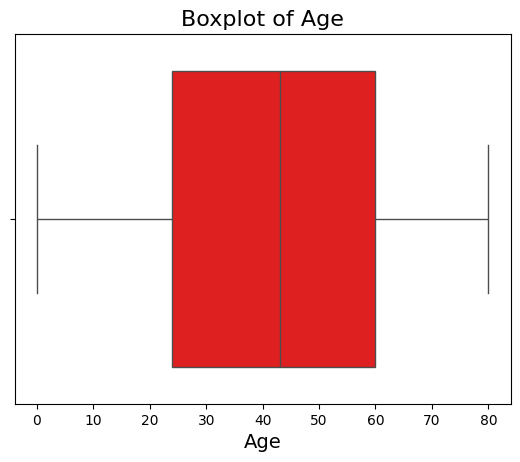

In [ ]:
sns.boxplot(x='age', data=df, color='red')
plt.title('Boxplot of Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.show()

The boxplot shows that in this dataset, Age ranges from 0 to 80 years old. There are no lone dots in the plot for Age, so there are no outliers within this column.

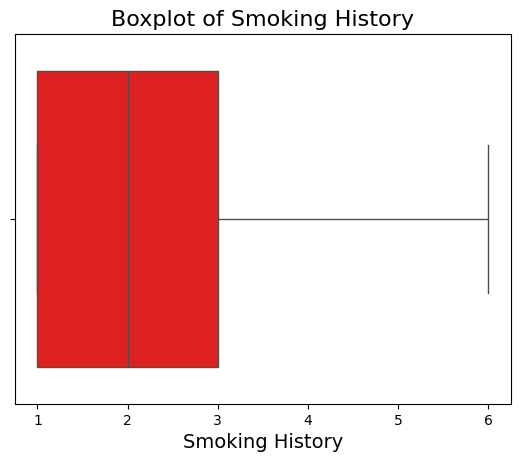

In [ ]:
sns.boxplot(x='smoking_history', data=df, color='red')
plt.title('Boxplot of Smoking History', fontsize=16)
plt.xlabel('Smoking History', fontsize=14)
plt.show()

Smoking History is scored on a scale from 1-6, the higher the score being a greater smoking history. There are no lone dots in the plot for Smoking History, so there are no outliers within this column.

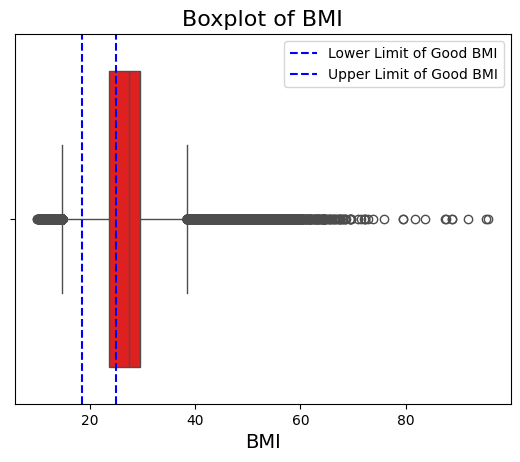

In [ ]:
sns.boxplot(x='bmi', data=df, color='red')
plt.title('Boxplot of BMI', fontsize=16)
plt.xlabel('BMI', fontsize=14)
good_bmi_range = (18.5, 24.9)
plt.axvline(good_bmi_range[0], color='blue', linestyle='--', label='Lower Limit of Good BMI')
plt.axvline(good_bmi_range[1], color='blue', linestyle='--', label='Upper Limit of Good BMI')
plt.legend()
plt.show()

The plot for BMI contains many lone dots. However, BMI itself as a measure naturally varies greatly from person to person. The fact that a numerous amount of points were considered outliers by the plot supports this idea. Thus, we will not consider BMI as having potential for outliers. It's also worth noting that the dotted lines indicate the range of a healthy BMI, and the majority of patients in this dataset do not fall in this range.

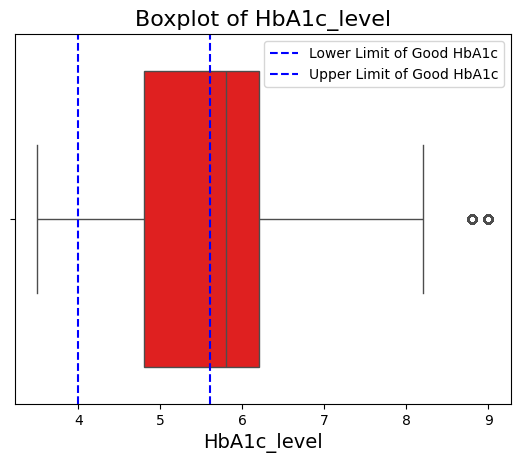

In [ ]:
sns.boxplot(x='HbA1c_level', data=df, color='red')
plt.title('Boxplot of HbA1c_level', fontsize=16)
plt.xlabel('HbA1c_level', fontsize=14)
good_hba1c_range = (4.0, 5.6)
plt.axvline(good_hba1c_range[0], color='blue', linestyle='--', label='Lower Limit of Good HbA1c')
plt.axvline(good_hba1c_range[1], color='blue', linestyle='--', label='Upper Limit of Good HbA1c')
plt.legend()
plt.show()

The plot seems to show outliers for HbA1c Levels close to 9.0. We can consult the value counts of that column to decide whether to drop the outliers or not. It is worth noting that the dotted lines represent the range for a normal HbA1c Level, and that a good portion of the people in this dataset do not fall in this range.

In [ ]:
df['HbA1c_level'].value_counts()

HbA1c_level
6.6    8540
5.7    8413
6.5    8362
5.8    8321
6.0    8295
6.2    8269
6.1    8048
3.5    7662
4.8    7597
4.5    7585
4.0    7542
5.0    7471
8.8     661
8.2     661
9.0     654
7.5     643
6.8     642
7.0     634
Name: count, dtype: int64

Since the HbA1c Levels of 8.8 and 9.0 constitute hundreds of patients, we cannot afford to drop these outliers from the dataset.

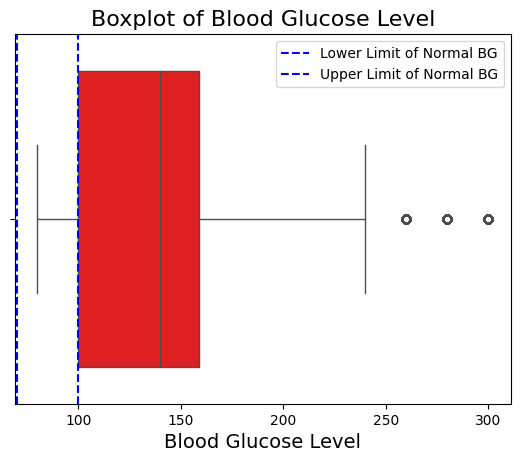

In [ ]:
sns.boxplot(x='blood_glucose_level', data=df, color='red')
plt.title('Boxplot of Blood Glucose Level', fontsize=16)
plt.xlabel('Blood Glucose Level', fontsize=14)
normal_bg_range = (70, 100)
plt.axvline(normal_bg_range[0], color='blue', linestyle='--', label='Lower Limit of Normal BG')
plt.axvline(normal_bg_range[1], color='blue', linestyle='--', label='Upper Limit of Normal BG')
plt.legend()
plt.show()

The plot seems to show outliers for Blood Glucose Levels above 250. We can consult the value counts of the column to decide whether to drop the outliers or not. The dotted lines show the normal range for blood glucose level. The vast majority of the people in this dataset have blood glucose levels above the normal range, suggesting this is a good predictor for diabetes.

In [ ]:
df['blood_glucose_level'].value_counts()

blood_glucose_level
130    7794
159    7759
140    7732
160    7712
126    7702
145    7679
200    7600
155    7575
90     7112
80     7106
158    7026
100    7025
85     6901
280     729
300     674
240     636
260     635
220     603
Name: count, dtype: int64

Since the Blood Glucose Levels of 260, 280, and 300 constitute hundreds of patients, we cannot afford to drop those patients from the dataset.

###Method 3: Chi-Square Test for Independence

We can use a chi-squre hypothesis test to determine the independence between categorical variables. In this case, we will compare smoking history with diabetes presence.  

H0 (Null): There is no significant correlation between smoking history and a person having diabetes.

HA (Alternative): There is a significant correlation between smoking history and a person having diabetes.

We can create a contingency table and perform the hypothesis test.

For both beginner and advanced readers, more information about the chi-square test can be found here: https://www.geeksforgeeks.org/ml-chi-square-test-for-feature-selection/

In [ ]:
# creating a contingency table with top 10k entries, using all data causes p-value to display as 0.0
contingency_table = pd.crosstab(df['smoking_history'].head(10000), df['diabetes'].head(10000))
# performing a chi-squared hypothesis test to determine p-value
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"P-value: {p_value}")

P-value: 1.0717452568607847e-44


As we can observe, the p-value is < 0.05 and we can thus reject the null hypothesis, concluding that there is a significant correlation between smoking history and a person having diabetes.

Next, we can visualize the contingency table using a heatmap.

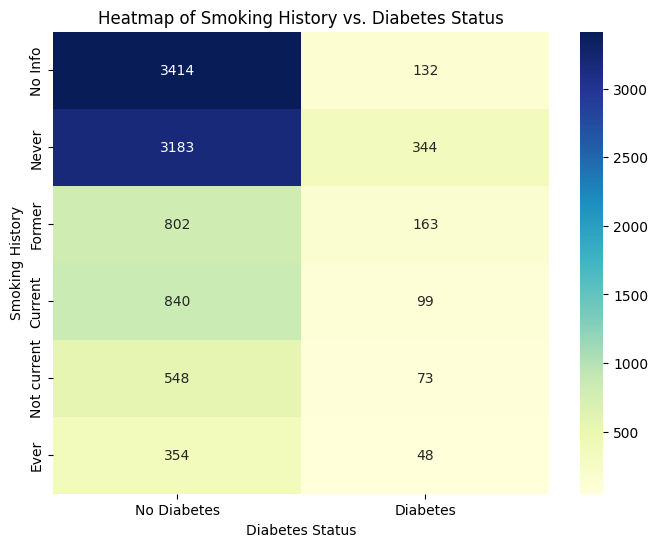

In [ ]:
# Labels for the axes
x_labels = ["No Diabetes", "Diabetes"]
y_labels = ["No Info", "Never","Former","Current","Not current","Ever"]

# Creating the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu", xticklabels=x_labels, yticklabels=y_labels)

# Adding titles and labels for clarity
plt.title('Heatmap of Smoking History vs. Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Smoking History')
plt.show()

It's clear the frequency for each category of smoking history differs quite a lot, and we can better represent the correlation between variables by representing ratios in a bar chart.

Text(0, 0.5, 'Ratio')

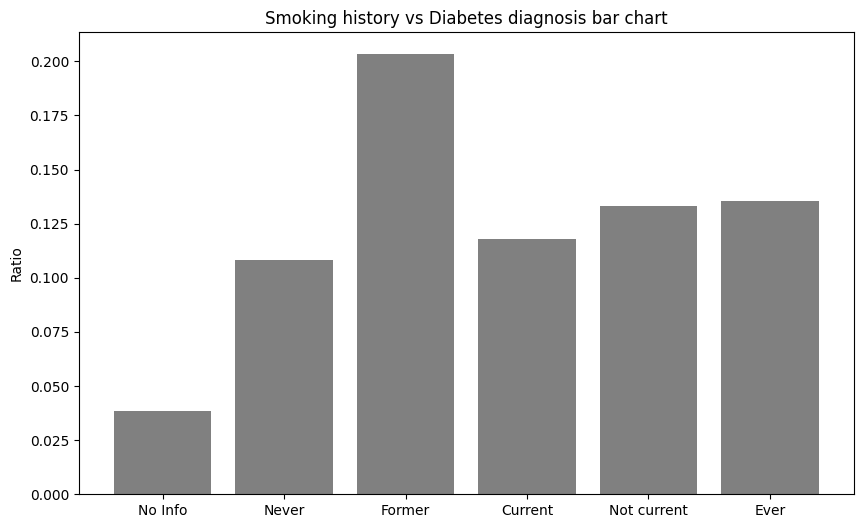

In [ ]:
categories = ["No Info", "Never","Former","Current","Not current","Ever"]
# obtain ratios, # of people with diabetes divided by # people w/o diabetes in each category
ratio_values = list(contingency_table[1] / contingency_table[0])

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, ratio_values, color='grey')
plt.title('Smoking history vs Diabetes diagnosis bar chart')
plt.ylabel('Ratio')

As we can see, former smokers are much more likely to be diagnosed with diabetes by a significant margin.

# Primary Analysis

To help predict whether a new patient has diabetes or not based on the features collected in the dataset, we will be training a machine learning model on the dataset. For this specific dataset, we will be utilizing a classification machine learning algorithm. This is because the label we are trying to predict, Diabetes, is a categorical variable with two categories: Yes (encoded as 1) or No (encoded as 0). The problem we are facing is deciding which label to assign a new patient not currently in the dataset, making classification the optimal algorithm to use. We will also be using a supervised classification algorithm, because the dataset already provides us with the diabetes label beforehand. We are able to train the machine learning model with the known labels.

We will be utilizing the Random Forest Classification Algorithm. This is because it is known to be the most accurate classification algorithm out there. Random Forest creates a set amount of different decision trees for classification and utilizes the results from all decision trees to perform the final classification of the person's label.

In [ ]:
y = df['diabetes']
X = df.drop('diabetes', axis=1)

X_encoded = pd.get_dummies(X, columns=['gender', 'smoking_history', 'hypertension'])

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# use kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=k_fold, scoring='accuracy')

# fit the model
rf_classifier.fit(X_train_scaled, y_train)

y_pred = rf_classifier.predict(X_test_scaled)

# get the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Cross-Validation Mean Accuracy:", cv_scores.mean())
print("Cross-Validation Accuracy Standard Deviation:", cv_scores.std())

Test Set Accuracy: 0.9704666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27453
           1       0.95      0.69      0.80      2547

    accuracy                           0.97     30000
   macro avg       0.96      0.84      0.89     30000
weighted avg       0.97      0.97      0.97     30000

Cross-Validation Mean Accuracy: 0.9701571428571428
Cross-Validation Accuracy Standard Deviation: 0.0011947162586888732


Our accuracies are very high! This
Random Forest Machine Learning Model can now be used to accurately classify new patients not currently in the dataset.

**If you're confused or would like to learn more, check out these resources:**

1) Cross validation: https://www.geeksforgeeks.org/cross-validation-machine-learning/

2) Decision trees & Random forest classifier: https://www.ibm.com/topics/random-forest#:~:text=Random%20forest

# Visualization


We can create a confusion matrix heat map to visualize the overall accuracy of our model!

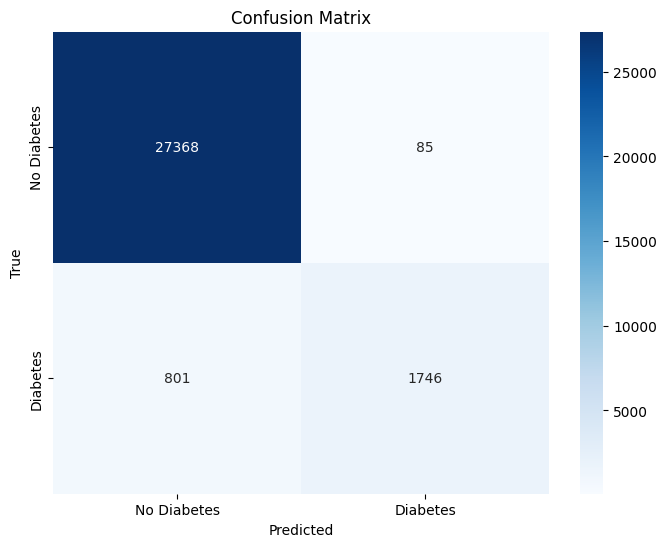

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Confusion Matrix/Heat Map analysis

Each cell in the confusion matrix shows either the count of true positives, false positives, true negatives, or false negatives. The confusion matrix shows our model is very good at predicitng those without the condition, evident by the high number of true negatives relative to false positives. The plot also suggests there might be room for improving the model, especially in terms of catching more true cases of diabetes.


If you're **confused**, here is a **comprehensive** overview of the **confusion** matrix: https://indhumathychelliah.com/2020/12/23/confusion-matrix

# Insights and conclusions

**On our model:**
- Our Random Forest classifier model achieved an impressive accuracy of ~97% when predicting diabetes on unseen data. Also, the model has a high precision+recall for the "No Diabetes" class, but is slightly lacking in the recall department for the "Diabetes" class.

**Overall:**
- In this tutorial, we traversed the data science pipeline comprehensively, depicting how data science can be used as a tool to identify individuals at risk of diabetes. We covered the procurement of the dataset via kaggle, the parsing and preprocessing of the data, hypothesis testing and data analysis using t-test and chi-square with insightful visuals, and machine learning using a random forest classification model to predict diabetes on unseen data.
Throughout the tutorial, hyperlinks to websites offering helpful and additional information on the methods covered were provided for further learning. We believe this tutorial contains valuable learning content for everyone, whether you are a beginner or an expert in data science!